<a href="https://colab.research.google.com/github/YannMaa/traco_2024/blob/main/Reference-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reference Solution

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ab hier Loss function(dice loss)

In [41]:
class loss():
  #
  def dice_loss(pred, target, smooth = 1.):
      pred = pred.contiguous()
      target = target.contiguous()

      intersection = (pred * target).sum(dim=2).sum(dim=2)

      loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

      return loss.mean()

## Ab hier Model Aufbau

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.models import resnet18, ResNet18_Weights
import math
from torchvision import transforms
import time
from matplotlib import pyplot as plt
import numpy as np

def convrelu(in_channels, out_channels, kernel, padding):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        torch.nn.ReLU(inplace=True),
    )

from collections import defaultdict
import torch.nn.functional as F


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.9):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


class ResNetUNet(torch.nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        #self.hidden_size1 = 64
        #self.hidden_size2
        #self.hidden_size3
        #self.hidden_size4

        self.layer0 = torch.nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = torch.nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = torch.nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)#skip connections
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out



In [43]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/My Drive/traco_2024/reference-model.pth', weights_only=False)

### Video einlesen und model testen

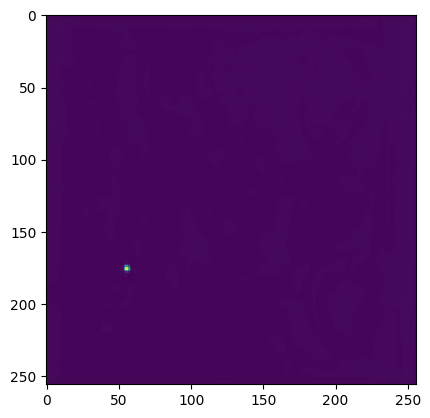

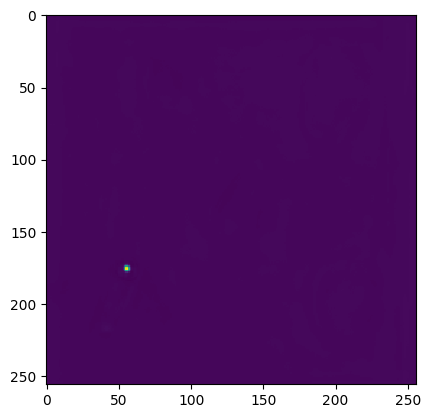

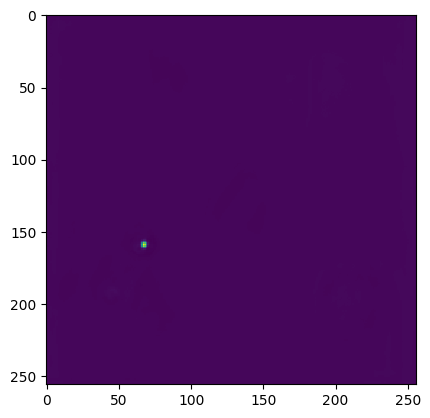

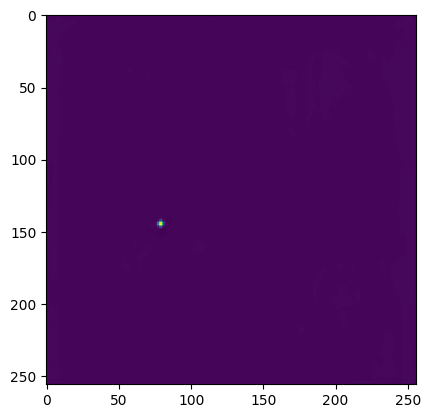

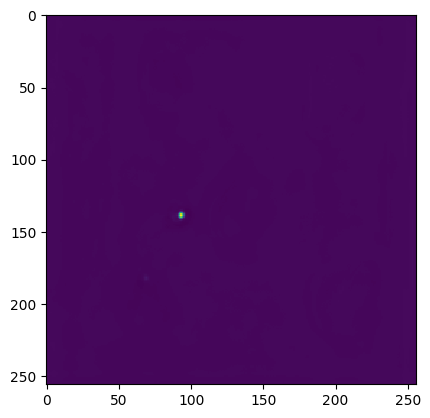

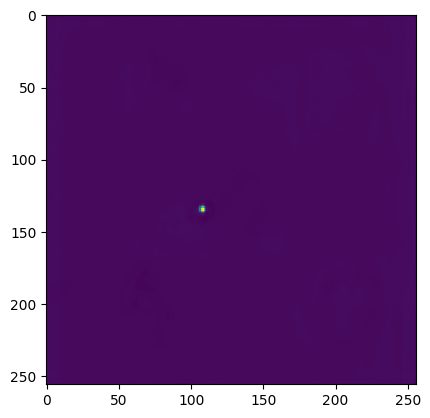

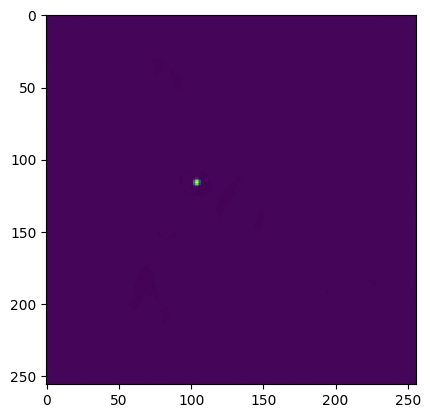

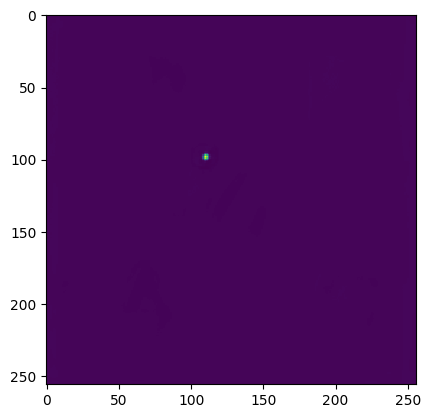

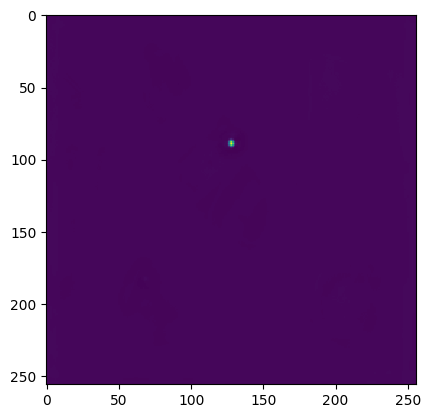

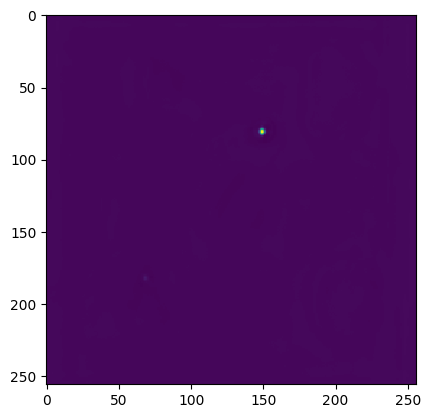

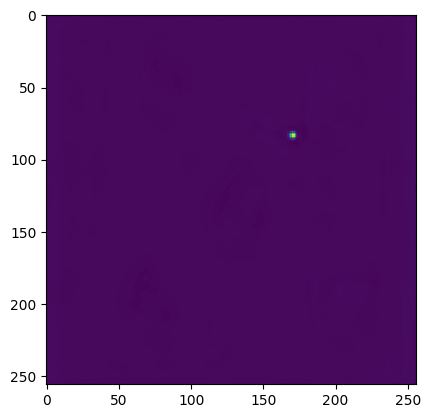

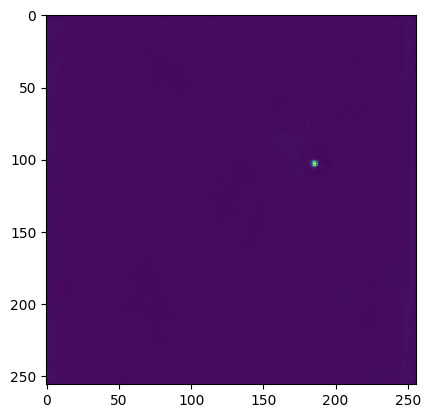

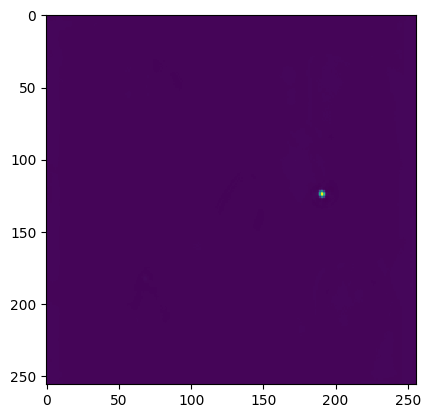

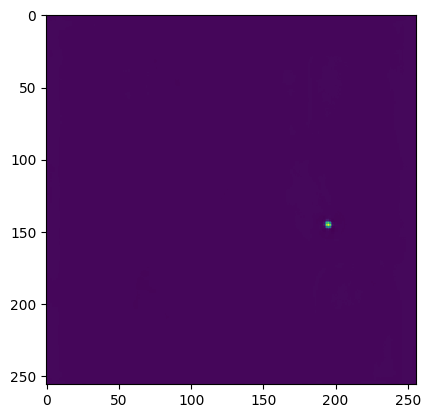

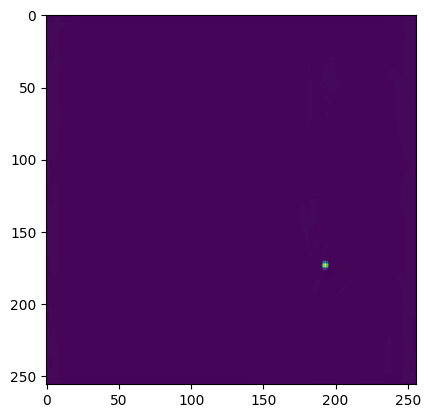

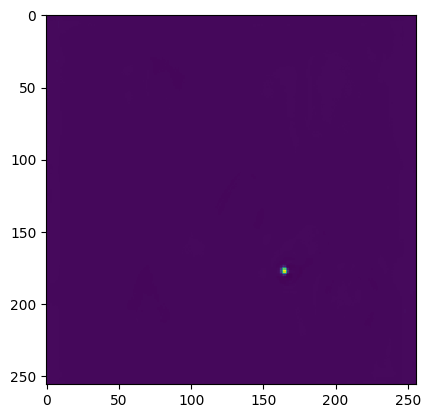

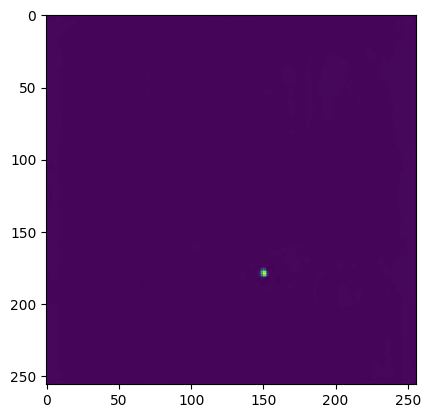

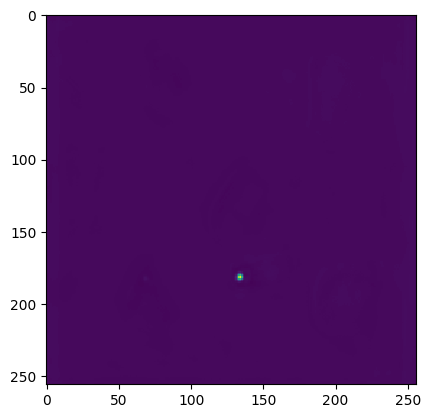

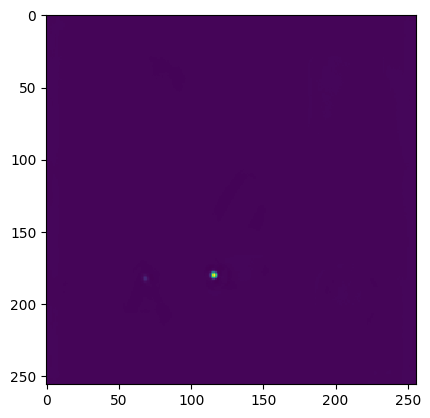

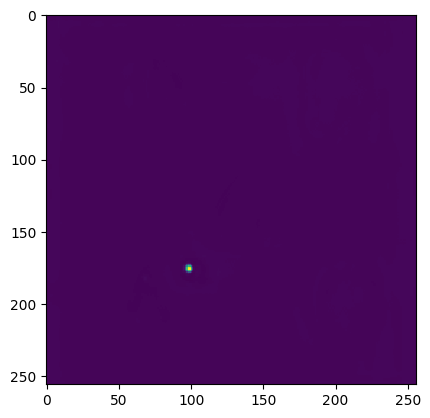

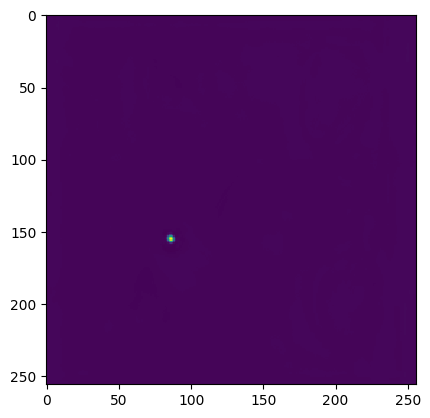

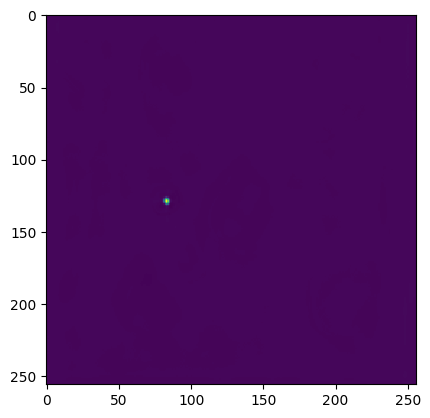

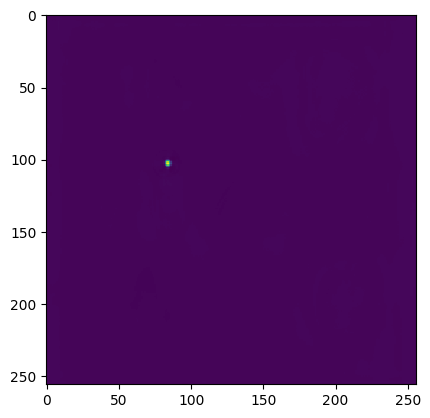

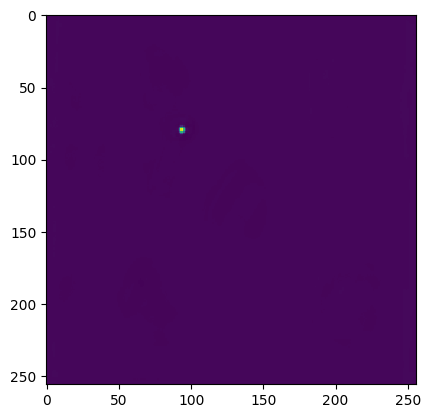

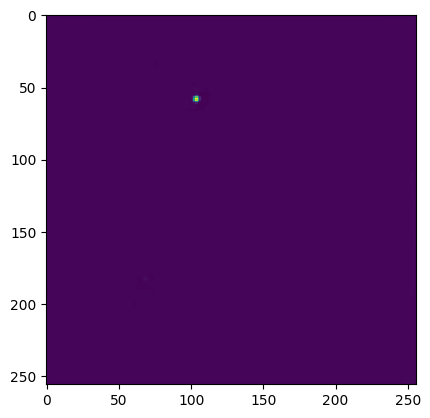

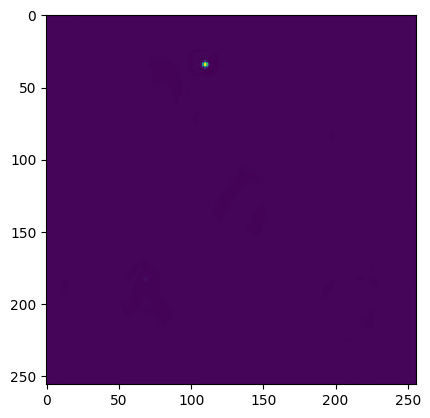

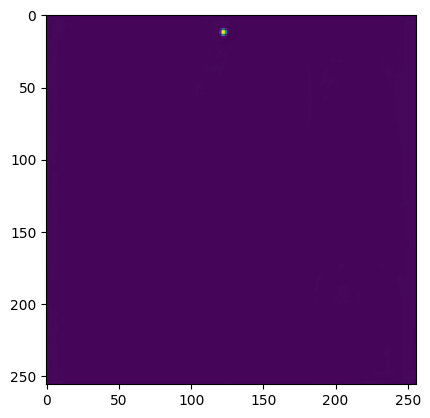

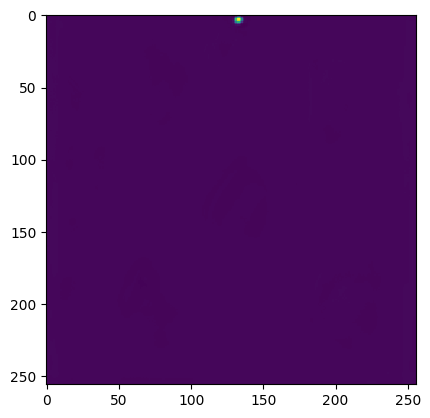

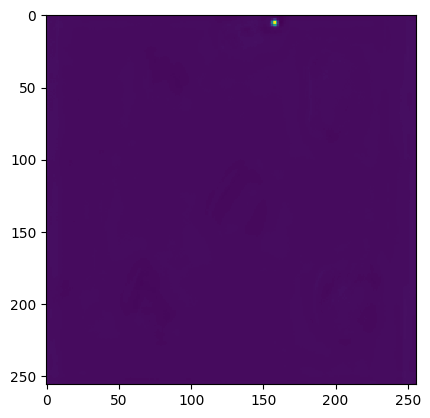

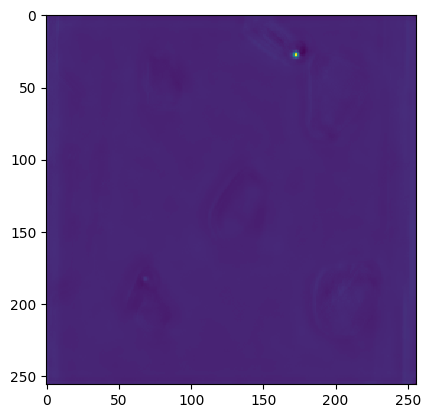

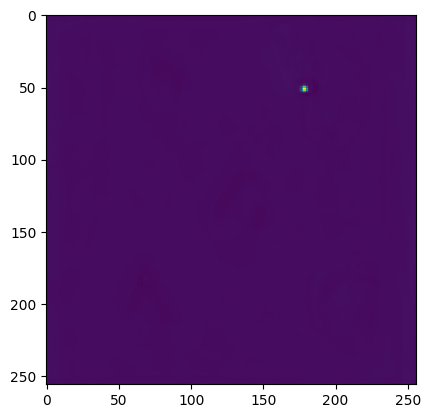

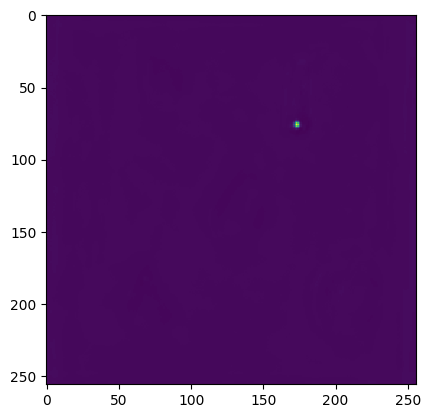

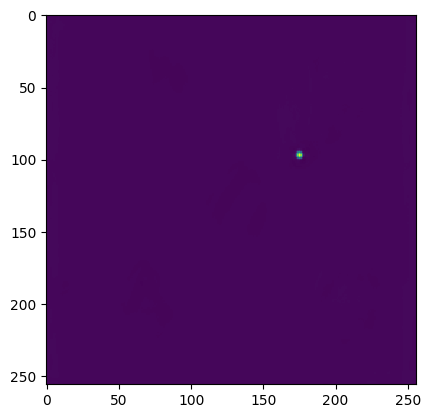

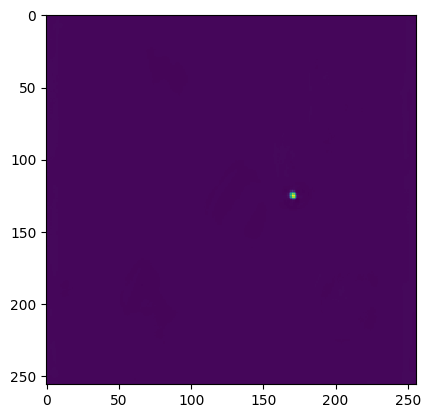

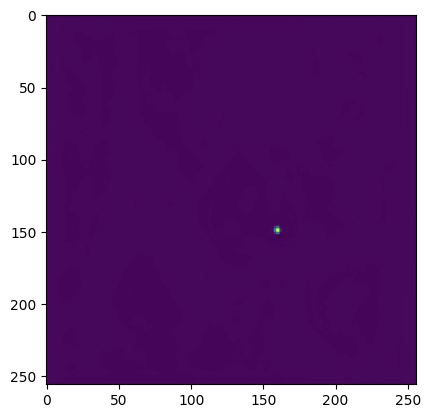

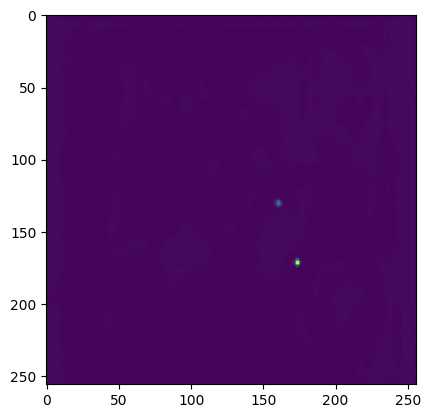

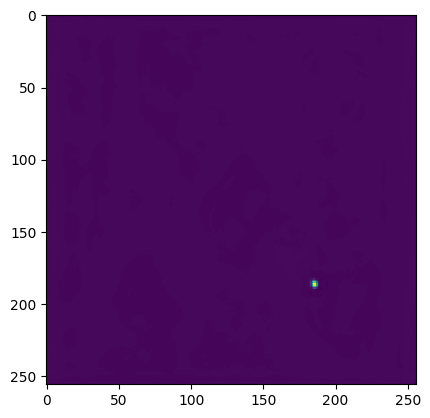

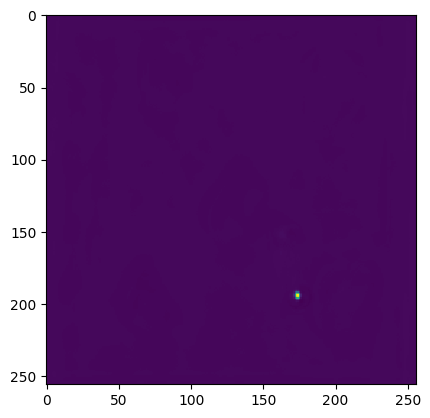

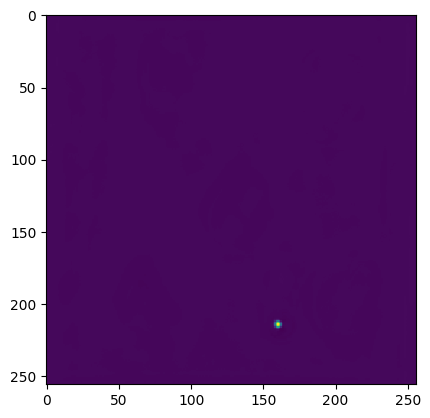

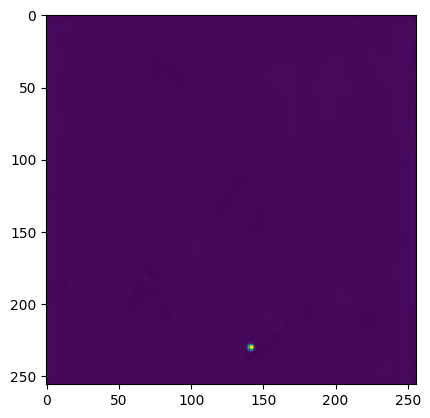

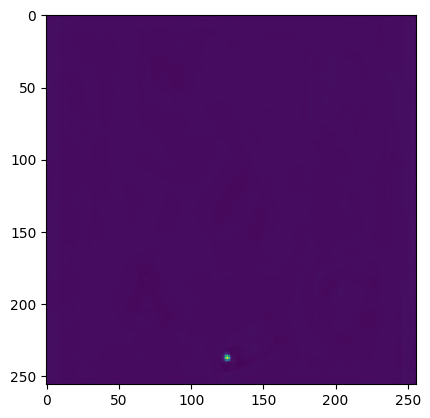

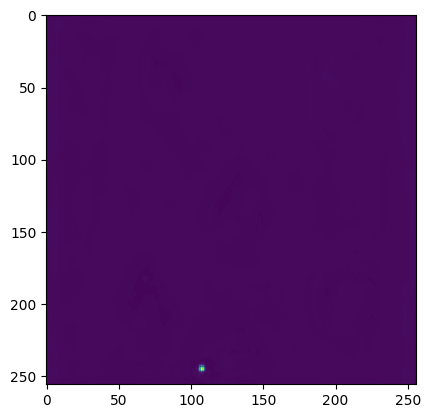

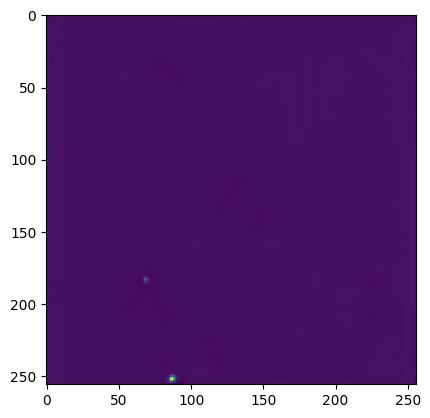

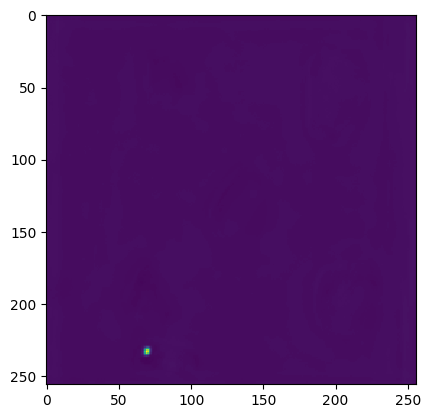

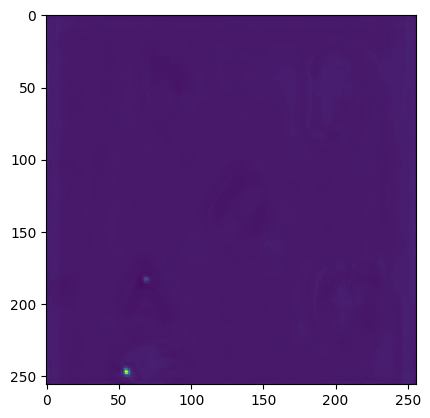

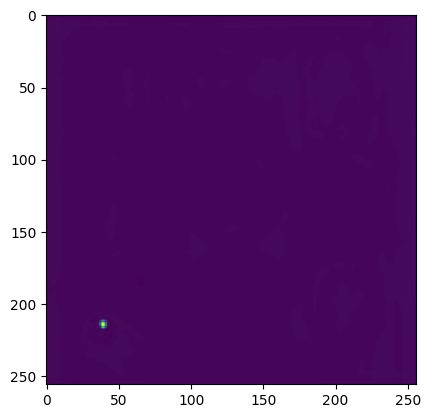

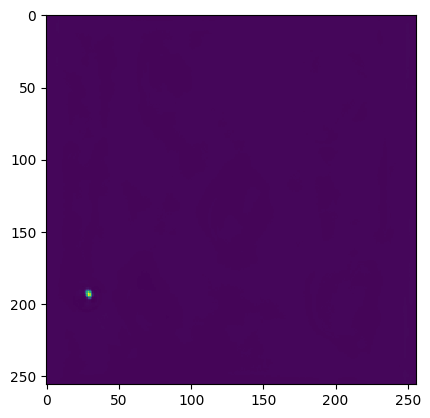

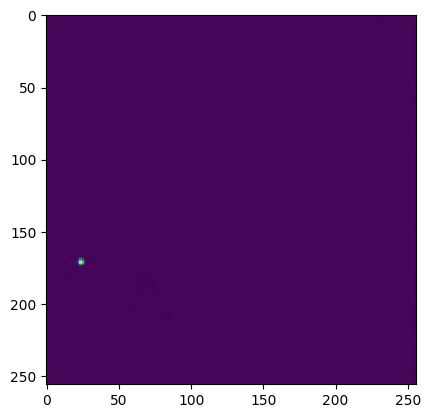

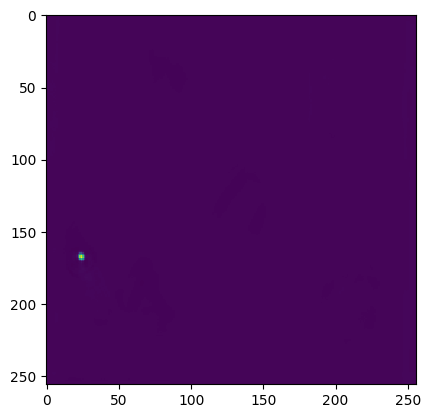

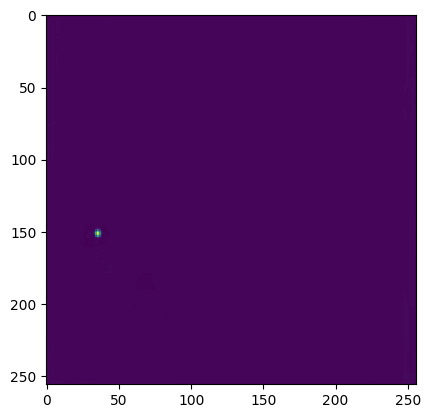

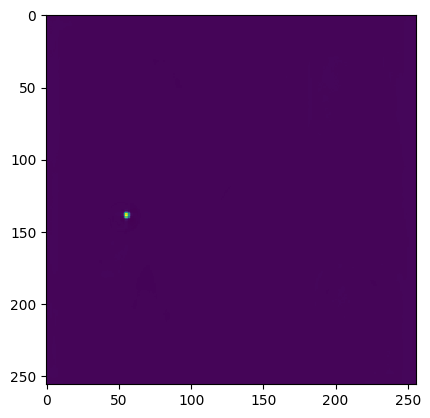

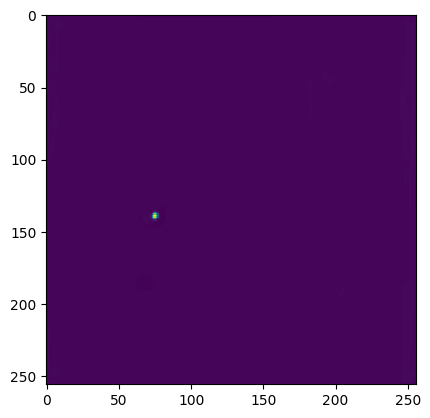

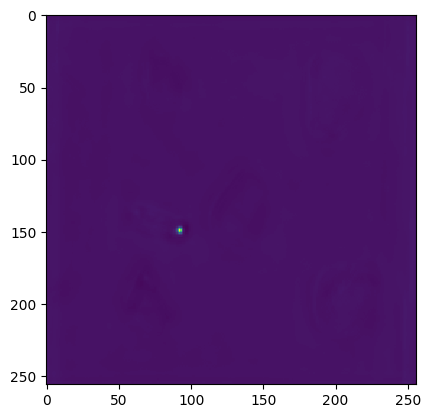

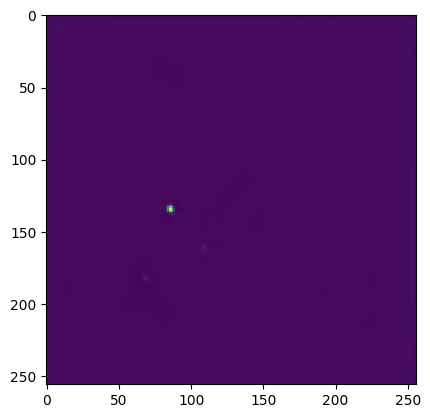

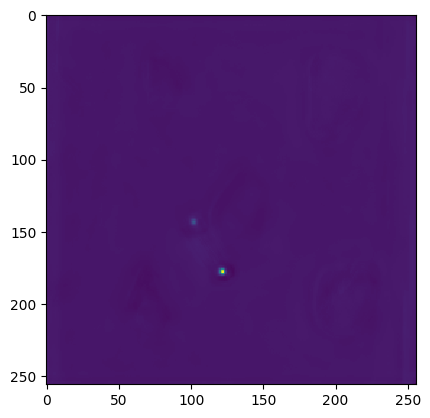

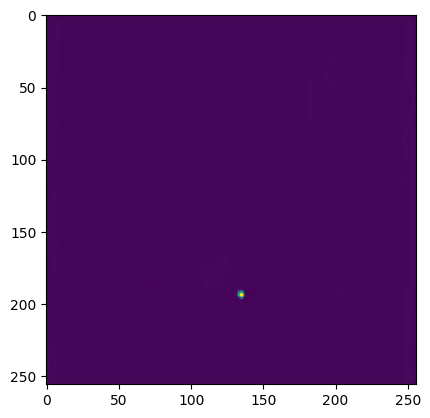

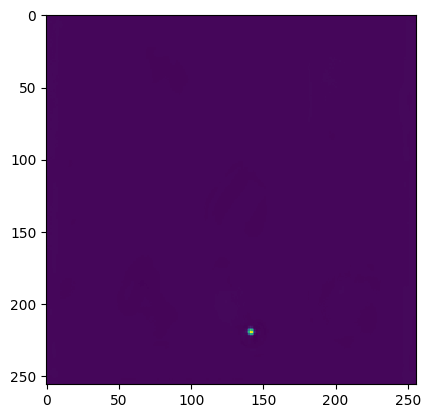

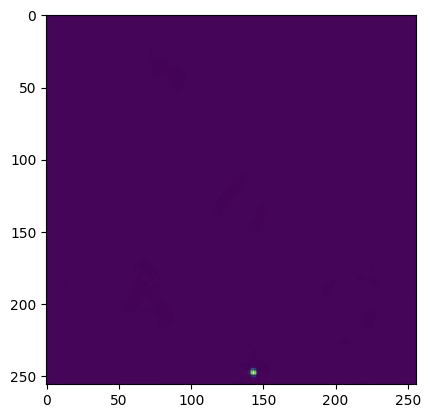

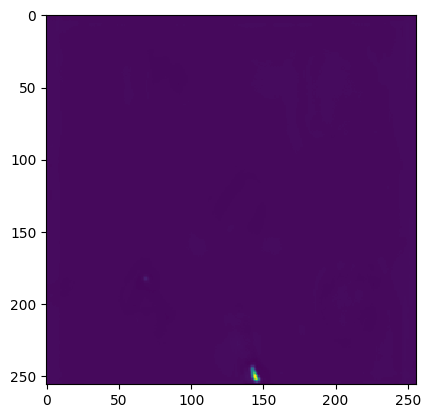

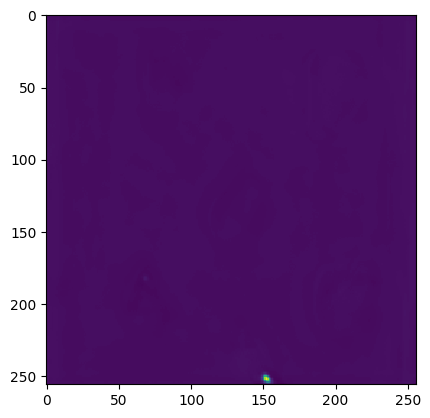

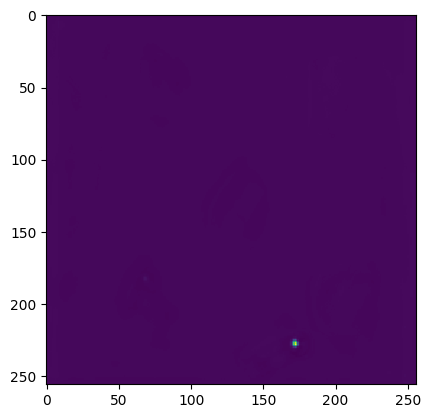

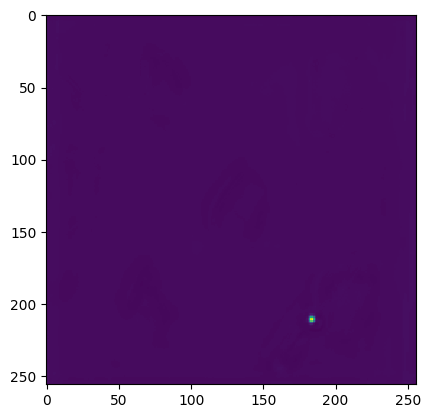

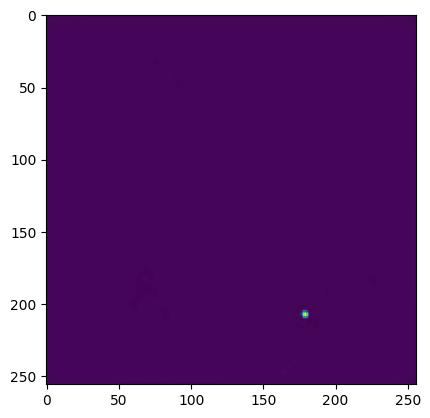

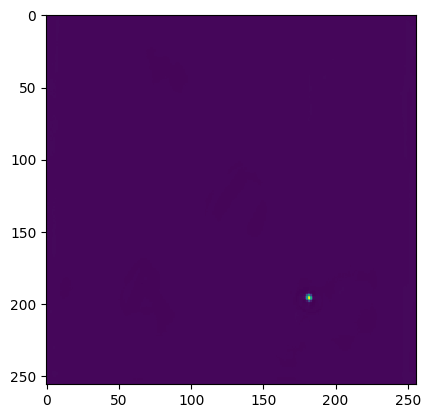

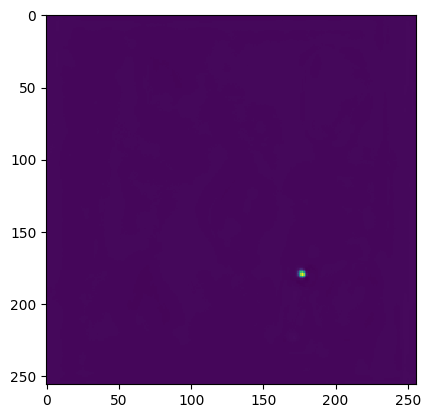

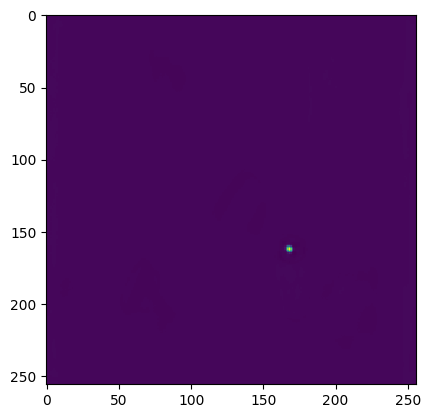

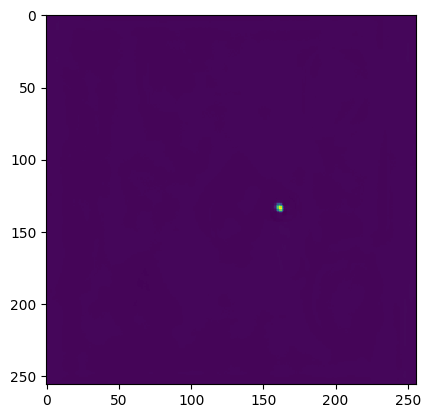

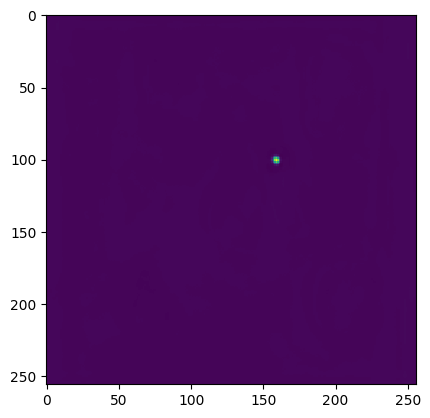

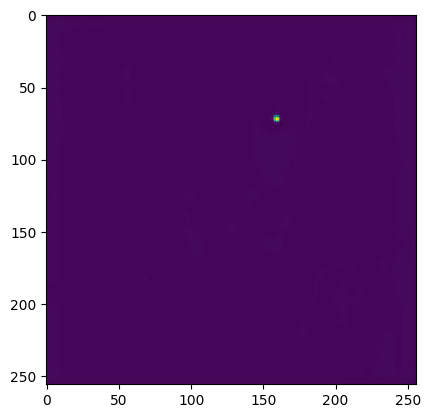

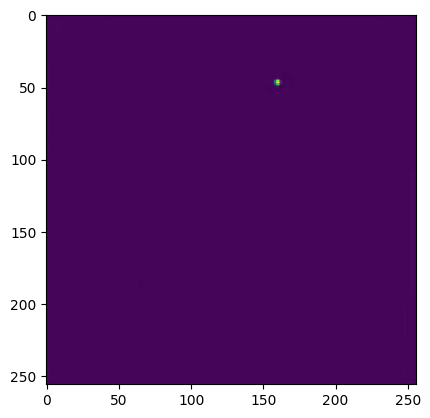

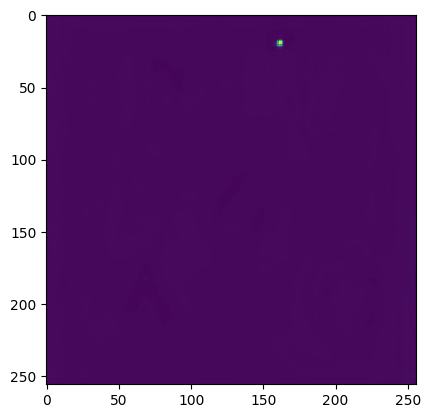

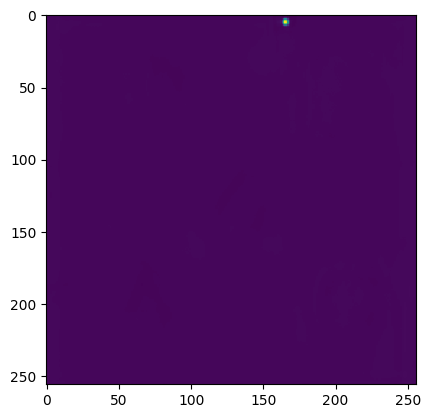

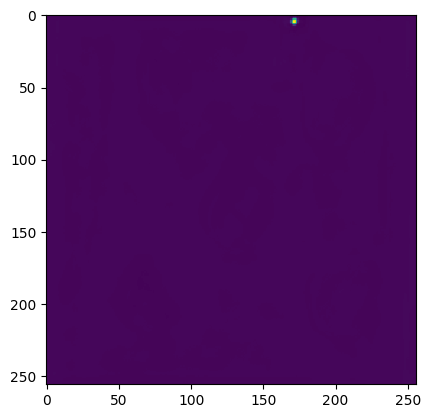

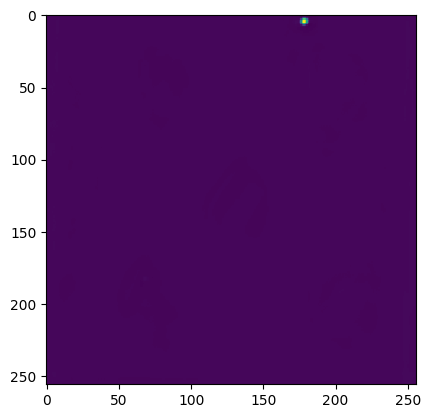

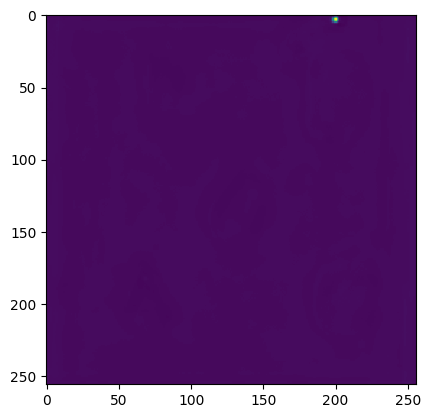

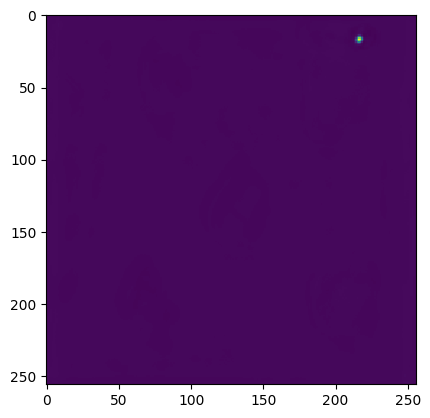

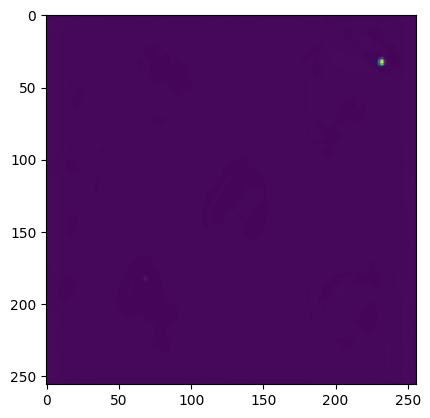

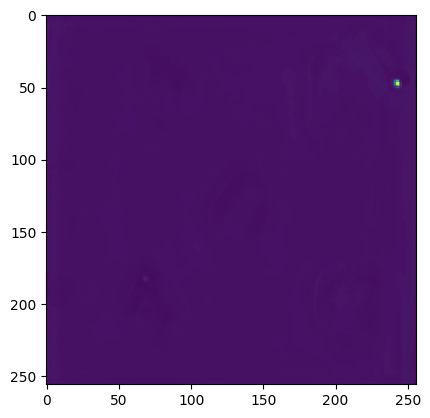

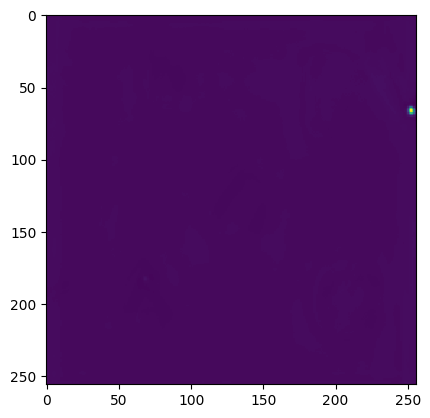

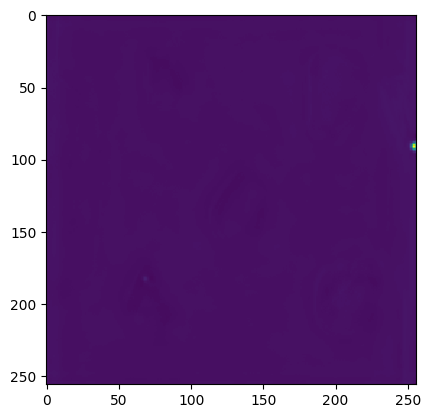

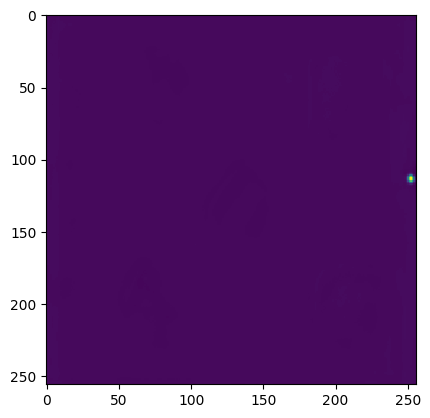

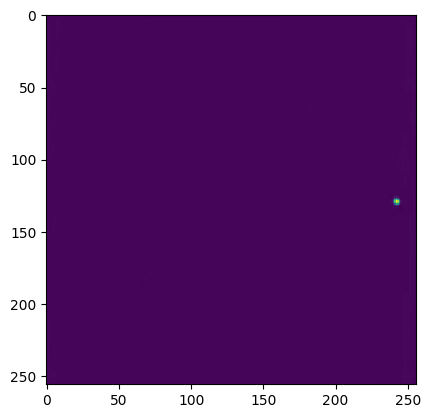

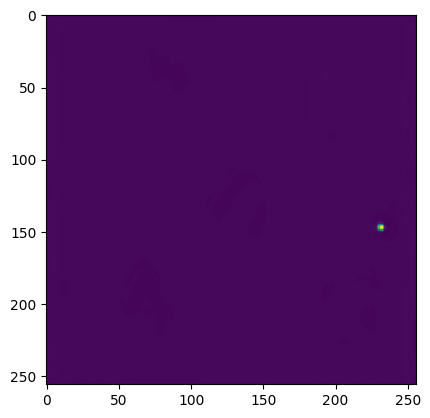

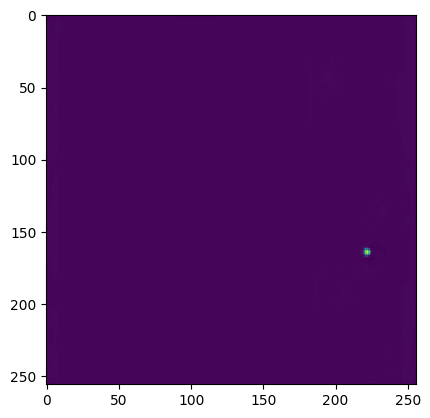

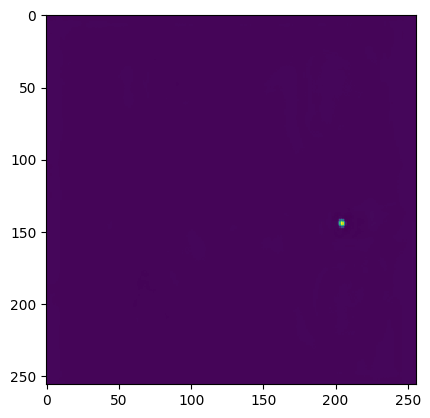

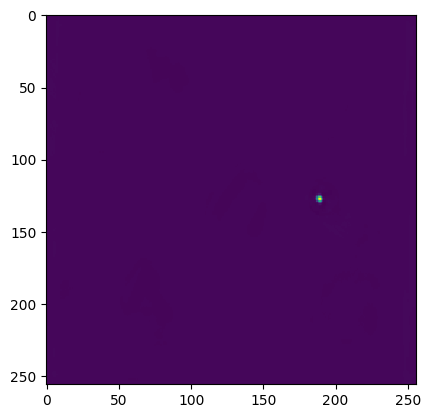

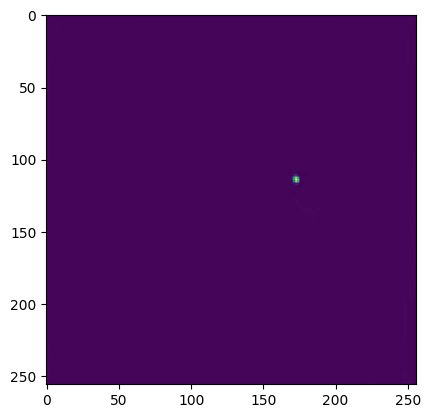

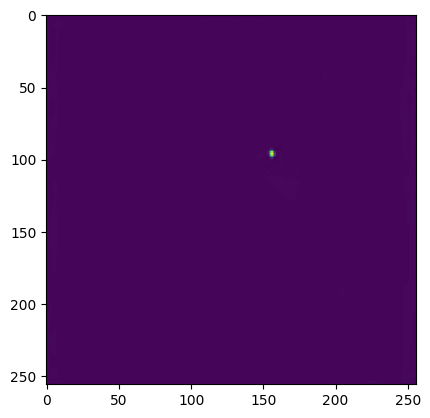

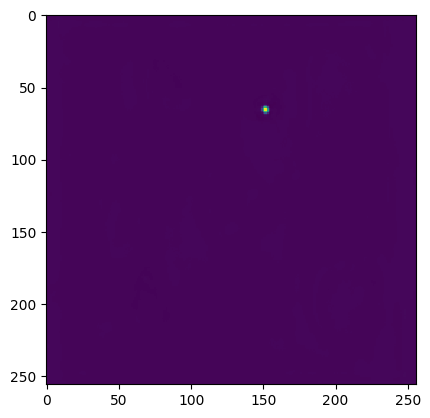

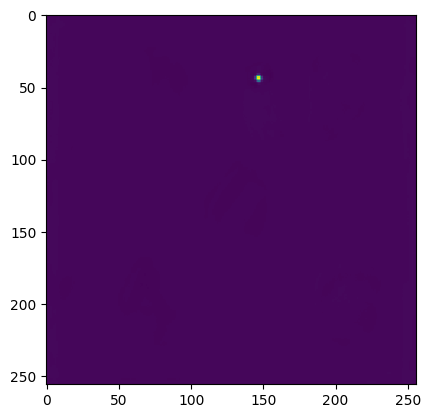

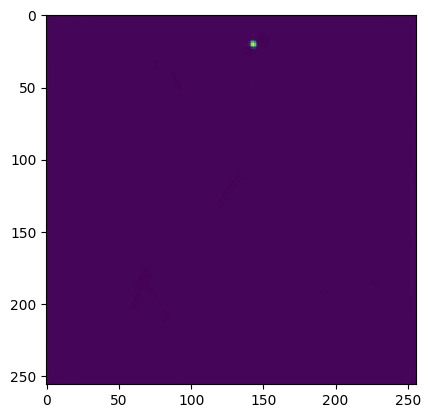

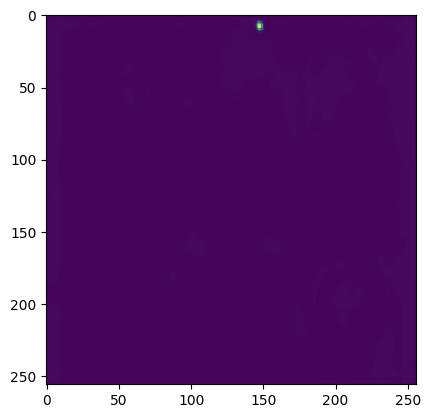

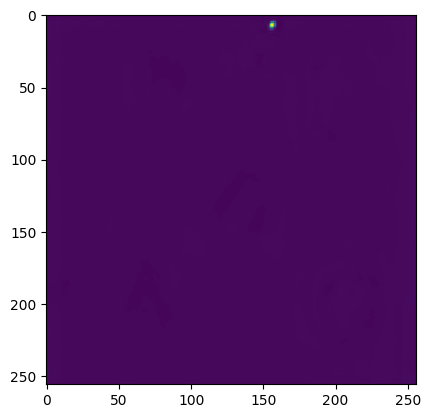

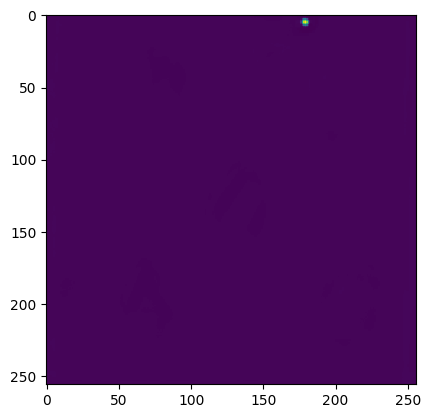

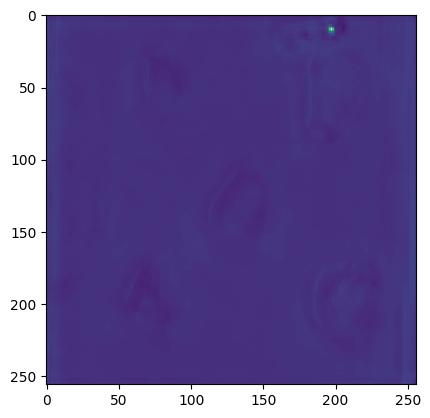

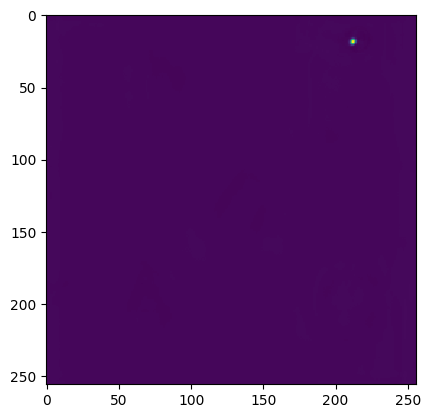

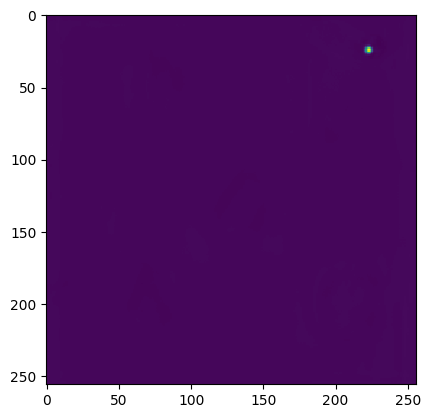

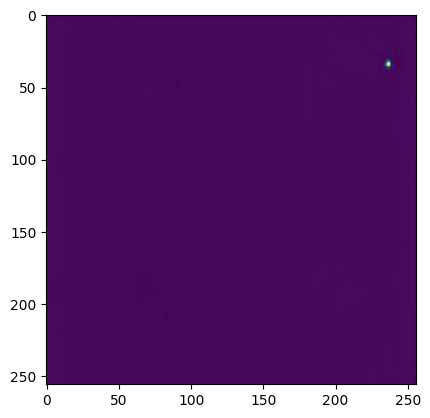

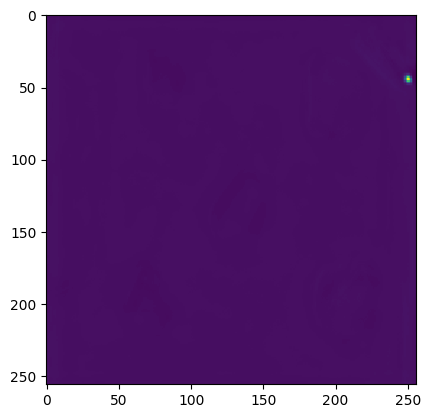

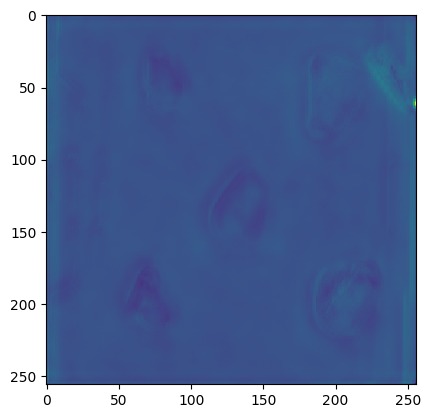

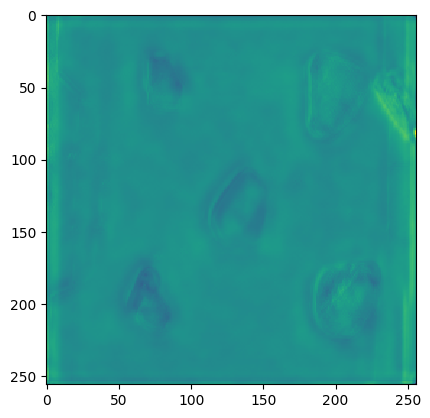

101


In [51]:
import torch
import time
from torch.utils.data import Dataset
import pickle
import numpy as np
import cv2
from matplotlib import pyplot as plt
cap = cv2.VideoCapture("/content/drive/My Drive/traco_2024/training/training01.mp4")
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fc = 0
ret = True
prediction = []
transform = transforms.Compose([transforms.ToTensor()])
frameWidth,frameHeight,channels =0,0,0
while (fc < frameCount and ret):
  #take frame
  ret, buf = cap.read()
  # convert to RGB
  im_rgb = cv2.cvtColor(buf, cv2.COLOR_BGR2RGB)
  #resize frame
  im_rgb = cv2.resize(im_rgb, dsize=(256,256))

  #get frame size
  frameWidth1,frameHeight1,channels1 = buf.shape
  frameWidth,frameHeight,channels = frameWidth1,frameHeight1,channels1

  #bild ans model geben
  im_rgb = transform(im_rgb)
  img = torch.unsqueeze(im_rgb,0).to(device)
  some_result = model(img)
  some_result = torch.squeeze(some_result,0)
  some_result = torch.squeeze(some_result,0)
  some_result = some_result.cpu().detach().numpy()
  plt.imshow(some_result, interpolation='nearest')
  plt.show()
  #hier speichern
  prediction.append(some_result)
  fc += 1
print(fc)


# Ab hier das max instensity herrausfinden

In [52]:
def get_densest_numpy_patches(image):
  radius = 10
  maximum_value_list = []
  #get maximum value coordinates
  a = np.argmax(image)
  l=image.shape[0]
  c = a%l
  r = int(a/l)
  #make threshold the first highest value that could be found
  threshold = image[r,c]/2
  #print((r*l+c)==a)
  k=0
  #for every pixel that is at least as intens as the first
  #Annahme: Alle Köpfe haben am Ende wenigstens einen Pixel mit der höchsten intensität. Ansonsten einfach eine Range von 5 % einrichten threshold * 0.95
  #while image[r,c] >= threshold:
  NUMBER_OF_HEX = 3
  for i in range(NUMBER_OF_HEX):
    if( r < 5 or c < 5 ):
      passes = False
      while(passes == False):
        image = cv2.circle(image, (c,r), 2,0, -1)
        a = np.argmax(image)
        l=image.shape[0]
        c = a%l
        r = int(a/l)
        if(r <5 or c<5):
          passes = True
    k+=1
    #print(r,c)
    i=r
    j=c
    #Alle pixel darum auf 0 setzten damit argmax neuen höchsten finden kann
    image = cv2.circle(image, (c,r), radius,0, -1)
    #f1 = plt.figure(k)
    #plt.imshow(image, interpolation='nearest')
    #Höhepunkt hinzufügen
    maximum_value_list.append([c,r])
    a = np.argmax(image)
    c = a%256
    r = int(a/256)
  return maximum_value_list

In [53]:
###hier wird weitergemacht und die peaks gesucht
list_max_value_unordered = []
for i in prediction:
  list = get_densest_numpy_patches(i)
  list_max_value_unordered.append(list)

In [54]:
print(len(list_max_value_unordered))

101


In [55]:
print(list_max_value_unordered)

[[[np.int64(56), 176], [np.int64(41), 217], [np.int64(1), 77]], [[np.int64(56), 176], [np.int64(41), 217], [np.int64(1), 77]], [[np.int64(67), 159], [np.int64(47), 190], [np.int64(253), 148]], [[np.int64(79), 145], [np.int64(1), 45], [np.int64(253), 151]], [[np.int64(93), 139], [np.int64(69), 182], [np.int64(1), 45]], [[np.int64(108), 134], [np.int64(1), 43], [np.int64(253), 180]], [[np.int64(104), 116], [np.int64(1), 77], [np.int64(253), 164]], [[np.int64(110), 98], [np.int64(1), 42], [np.int64(253), 138]], [[np.int64(128), 89], [np.int64(68), 183], [np.int64(1), 43]], [[np.int64(149), 81], [np.int64(68), 182], [np.int64(1), 251]], [[np.int64(170), 83], [np.int64(1), 77], [np.int64(253), 158]], [[np.int64(186), 103], [np.int64(253), 145], [np.int64(1), 45]], [[np.int64(191), 124], [np.int64(68), 183], [np.int64(1), 77]], [[np.int64(195), 145], [np.int64(253), 146], [np.int64(1), 248]], [[np.int64(193), 173], [np.int64(253), 145], [np.int64(253), 180]], [[np.int64(165), 177], [np.int64

## Ab hier list erstellen mit Positions in richtiger reihenfolge der IDs

Angewendet auf somedata

In [56]:
list_max_value_ordered = []
#ordered list is first row
list_max_value_ordered = [list_max_value_unordered[0]]
def assign_ID():
  #Die länge der positionen ist die länge des ersten prediction
  pos_sum = len(list_max_value_unordered[0])
  global list_max_value_ordered
  #über alle prediction iterieren, ersten weglassen
  for i in range(1,np.shape(list_max_value_unordered)[0]):
    #get coordinates
    for l in range(pos_sum):
      pos1 = list_max_value_ordered[i-1]
      pos2 = list_max_value_unordered[i]
    # neuen eintrag machen in der länge der anzahl der hexbug
    pp=[]
    for o in range(pos_sum):
      pp.append([0,0])
    list_max_value_ordered.append(pp)

    #calculate shortest distance
    for j in range(pos_sum):
      d_shortest =10000
      index = 0
      for k in range(len(pos2)):
        #minimale strecke berechnen
        d = np.sqrt((pos1[j][0]-pos2[k][0])**2 + (pos1[j][1]-pos1[k][1])**2)
        #und wenn strecke kleiner dann indices abspeichern
        if(d<d_shortest):
          d_shortest = d
          index = k
      list_max_value_ordered[i][j][0] = pos2[index][0]
      list_max_value_ordered[i][j][1] = pos2[index][1]
      #pos entfernen
      del pos2[index]


In [57]:
print(len(list_max_value_unordered))
print(list_max_value_unordered)
assign_ID()
print(list_max_value_ordered)
print(len(list_max_value_ordered))

101
[[[np.int64(56), 176], [np.int64(41), 217], [np.int64(1), 77]], [[np.int64(56), 176], [np.int64(41), 217], [np.int64(1), 77]], [[np.int64(67), 159], [np.int64(47), 190], [np.int64(253), 148]], [[np.int64(79), 145], [np.int64(1), 45], [np.int64(253), 151]], [[np.int64(93), 139], [np.int64(69), 182], [np.int64(1), 45]], [[np.int64(108), 134], [np.int64(1), 43], [np.int64(253), 180]], [[np.int64(104), 116], [np.int64(1), 77], [np.int64(253), 164]], [[np.int64(110), 98], [np.int64(1), 42], [np.int64(253), 138]], [[np.int64(128), 89], [np.int64(68), 183], [np.int64(1), 43]], [[np.int64(149), 81], [np.int64(68), 182], [np.int64(1), 251]], [[np.int64(170), 83], [np.int64(1), 77], [np.int64(253), 158]], [[np.int64(186), 103], [np.int64(253), 145], [np.int64(1), 45]], [[np.int64(191), 124], [np.int64(68), 183], [np.int64(1), 77]], [[np.int64(195), 145], [np.int64(253), 146], [np.int64(1), 248]], [[np.int64(193), 173], [np.int64(253), 145], [np.int64(253), 180]], [[np.int64(165), 177], [np.i

## Positionen in Json speichern

In [58]:
import json
print(list_max_value_ordered)
json_predicted = {}
json_predicted['rois'] = []
frame=0
for i in list_max_value_ordered:
  id=0
  for j in i:
    json_predicted['rois'].append({
    'z' : frame,
    'id' : id,
    'pos': j
    })
    id+=1
  frame +=1
print(json_predicted)

[[[np.int64(56), 176], [np.int64(41), 217], [np.int64(1), 77]], [[np.int64(56), 176], [np.int64(1), 77], [np.int64(41), 217]], [[np.int64(67), 159], [np.int64(47), 190], [np.int64(253), 148]], [[np.int64(79), 145], [np.int64(1), 45], [np.int64(253), 151]], [[np.int64(93), 139], [np.int64(1), 45], [np.int64(69), 182]], [[np.int64(108), 134], [np.int64(1), 43], [np.int64(253), 180]], [[np.int64(104), 116], [np.int64(1), 77], [np.int64(253), 164]], [[np.int64(110), 98], [np.int64(1), 42], [np.int64(253), 138]], [[np.int64(128), 89], [np.int64(1), 43], [np.int64(68), 183]], [[np.int64(149), 81], [np.int64(1), 251], [np.int64(68), 182]], [[np.int64(170), 83], [np.int64(1), 77], [np.int64(253), 158]], [[np.int64(186), 103], [np.int64(1), 45], [np.int64(253), 145]], [[np.int64(191), 124], [np.int64(1), 77], [np.int64(68), 183]], [[np.int64(195), 145], [np.int64(1), 248], [np.int64(253), 146]], [[np.int64(193), 173], [np.int64(253), 180], [np.int64(253), 145]], [[np.int64(165), 177], [np.int64

In [59]:
import csv

# Open a CSV file in write mode
with open('predicted_data.csv', mode='w', newline='') as csv_file:
    # Define the fieldnames for the CSV file
    fieldnames = ['','t', 'hexbug', 'x', 'y']

    # Create a CSV writer object
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(fieldnames)
    idx = 0
    # Write data from the list to the CSV file
    for t, frame in enumerate(list_max_value_ordered):
        for hexbug, pos in enumerate(frame):
            pos_x = np.round((pos[0]/256)*frameHeight,2)
            pos_y = np.round((pos[1]/256)*frameWidth,2)
            x, y = pos_x, pos_y
            writer.writerow([idx,t, hexbug, x, y])
            idx += 1

print("CSV file has been created successfully!")


CSV file has been created successfully!
